In [1]:
import pandas as pd

from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# GLOBAL SETTINGS

# Data directories

#coin_dataDir = 'DATA/TESTDIR/' # Debug dir for testing I/O logic and/or issues. It should be a clone of the above dir.
model_dataDir = 'DATA/MODELDATA/'
plot_dataDir = 'DATA/INITIAL_INSIGHTS/MOMENTUM_FACTORS/STATINFER/'


# Helpers
idx = pd.IndexSlice
sns.set_style('whitegrid')

# END GLOBAL SETTINGS

In [3]:
# Read in MDF with initial coin pool
model_mdf = pd.read_csv(model_dataDir + 'ModelData.csv')
model_mdf.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)
model_mdf['Dates'] = pd.to_datetime(model_mdf['Dates'])
model_mdf.set_index(['Dates', 'Coin'], inplace=True)

# Drop NaNs and the OHLCV columns
data = (model_mdf
            .dropna()
            .drop(['Open', 'Close', 'Low', 'High', 'Volume'], axis=1))

# Ready the data for the model
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X.loc[:, 'year_2020':'month_12'] = X.loc[:, 'year_2020':'month_12'].astype('uint8')


# Month and year features causing infinite value error with the cluster map.
# While debugging this issue, X2 is a copy of X with the time factors removed, so the clustermap
# Does not crash the program.

X2 = X
mon = X2.filter(like='month')
X2 = X2.drop(mon.columns,axis=1)
mon = X2.filter(like='year')
X2 = X2.drop(mon.columns,axis=1)

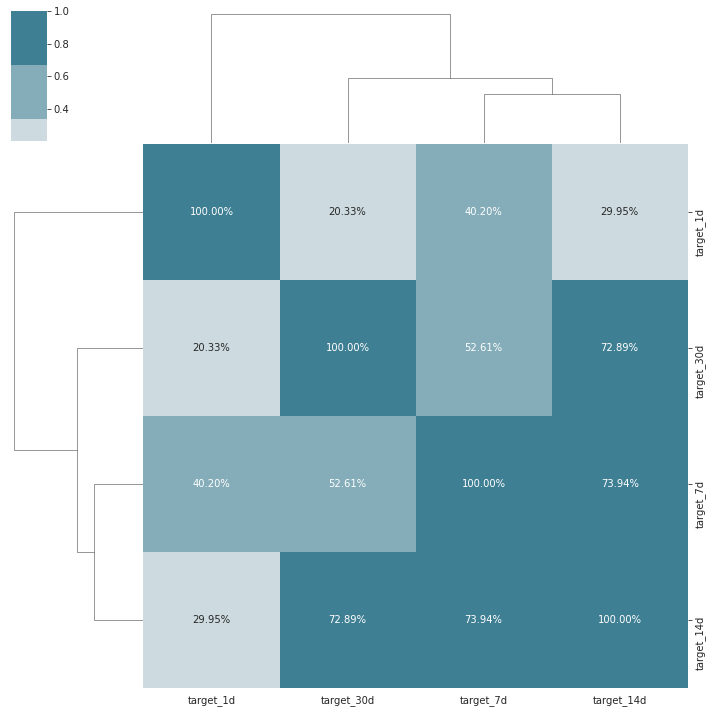

In [4]:
# Clustermap Divergence Pallete for y
j = sns.clustermap(y.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0, annot=True, fmt='.2%')

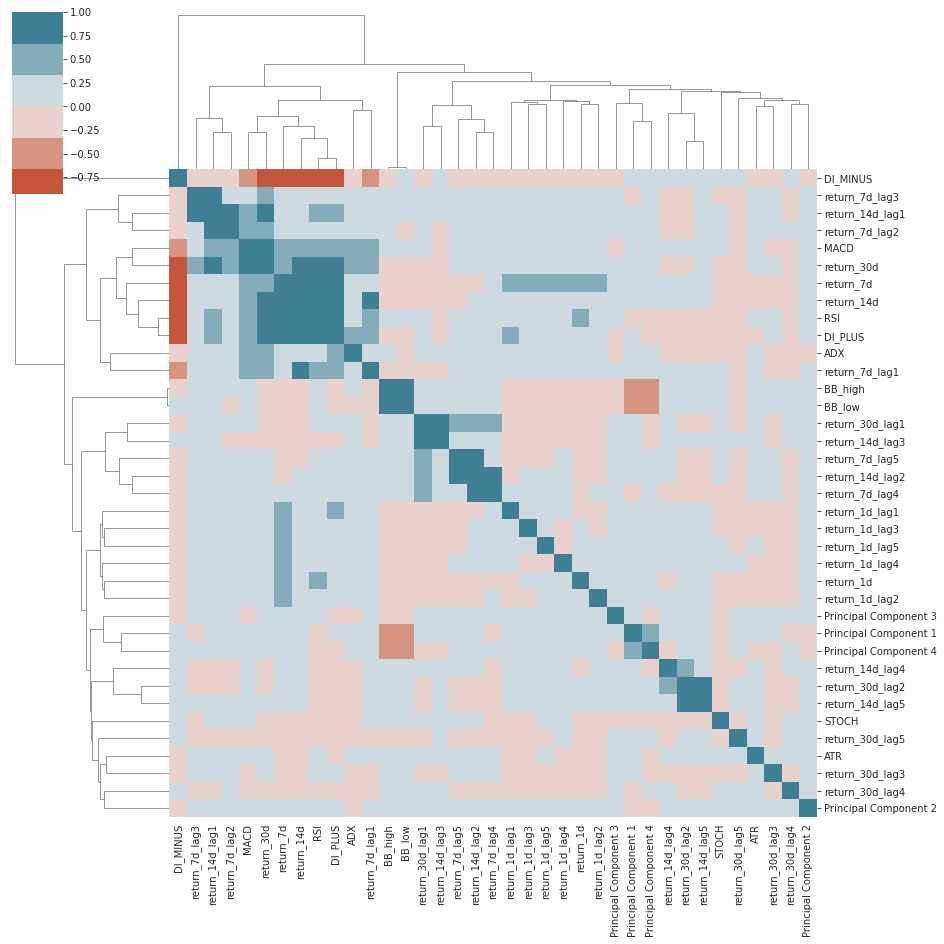

In [5]:
# Clustermap Divergence Pallete for X (X2)
j = sns.clustermap(X2.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0)
plt.gcf().set_size_inches((14, 14))

FEATURE CORRELATION:
         var1        var2      corr
103    BB_low     BB_high  0.989616
53    BB_high      BB_low  0.989616
357   DI_PLUS         RSI  0.923147
7         RSI     DI_PLUS  0.923147
187       ATR   year_2021  0.844434
419  DI_MINUS  return_14d -0.780380
365   DI_PLUS    DI_MINUS -0.849491
415  DI_MINUS     DI_PLUS -0.849491
408  DI_MINUS         RSI -0.923970
8         RSI    DI_MINUS -0.923970


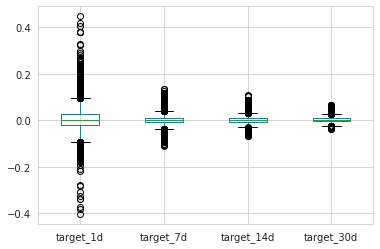

In [6]:
# Correlation matrix
print("FEATURE CORRELATION:")
corr_mat = X.corr().stack().reset_index()
corr_mat.columns=['var1', 'var2', 'corr']
corr_mat = corr_mat[corr_mat.var1!=corr_mat.var2].sort_values(by='corr', ascending=False)
print(corr_mat.head().append(corr_mat.tail()))

# Target value Boxplot
target_box = y.boxplot()
fig = target_box.get_figure()

In [7]:
# Statistical Inference with OLS from statsmodels

# Standardize the data by coin
X = (X.groupby(level='Coin')
     .transform(lambda x: (x - x.mean()) / x.std())
    .fillna(0))

# OLS against Daily targets
target = 'target_1d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()

print(f"OLS Regression results with {target} as the Y Target values".upper())
print(trained_model.summary())

# Obtaining residuals
preds = trained_model.predict(add_constant(X))
residuals = y[target] - preds

OLS REGRESSION RESULTS WITH TARGET_1D AS THE Y TARGET VALUES
                            OLS Regression Results                            
Dep. Variable:              target_1d   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     4.543
Date:                Fri, 11 Feb 2022   Prob (F-statistic):           4.31e-24
Time:                        14:26:42   Log-Likelihood:                 7056.7
No. Observations:                4615   AIC:                        -1.401e+04
Df Residuals:                    4563   BIC:                        -1.367e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


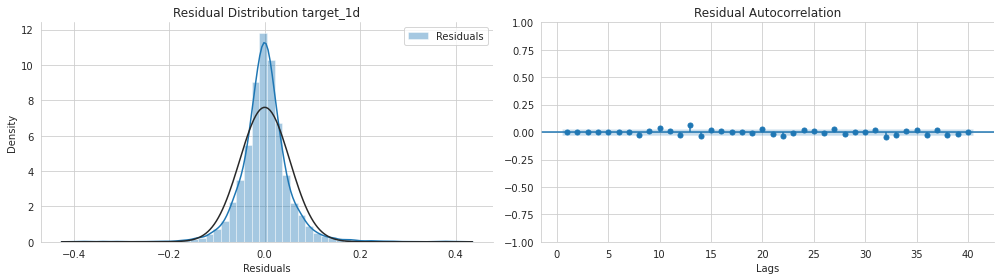

In [8]:
# Plot the residuals
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
res_plot = sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title(f'Residual Distribution {target}')
axes[0].legend()
plot_acf(residuals, lags=40, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout()

In [9]:
# OLS against Weekly targets
target = 'target_7d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()

print(f"OLS Regression results with {target} as the Y Target values".upper())
print(trained_model.summary())

# Obtaining residuals
preds = trained_model.predict(add_constant(X))
residuals = y[target] - preds

OLS REGRESSION RESULTS WITH TARGET_7D AS THE Y TARGET VALUES
                            OLS Regression Results                            
Dep. Variable:              target_7d   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     22.03
Date:                Fri, 11 Feb 2022   Prob (F-statistic):          3.42e-178
Time:                        14:26:43   Log-Likelihood:                 11819.
No. Observations:                4615   AIC:                        -2.353e+04
Df Residuals:                    4563   BIC:                        -2.320e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


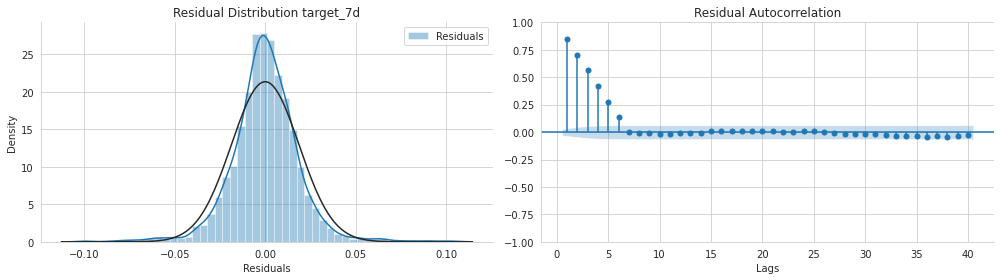

In [10]:
# Weekly Plot
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
res_plot = sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title(f'Residual Distribution {target}')
axes[0].legend()
plot_acf(residuals, lags=40, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout()

In [11]:
# OLS against bi-weekly targets
target = 'target_14d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()

print(f"OLS Regression results with {target} as the Y Target values".upper())
print(trained_model.summary())

# Obtaining residuals
preds = trained_model.predict(add_constant(X))
residuals = y[target] - preds

OLS REGRESSION RESULTS WITH TARGET_14D AS THE Y TARGET VALUES
                            OLS Regression Results                            
Dep. Variable:             target_14d   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     41.42
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:26:43   Log-Likelihood:                 13575.
No. Observations:                4615   AIC:                        -2.705e+04
Df Residuals:                    4563   BIC:                        -2.671e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


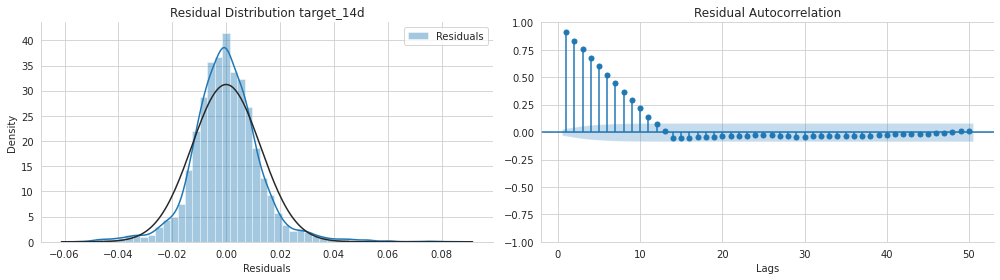

In [12]:
# Bi-Weekly OLS Plot
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
res_plot = sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title(f'Residual Distribution {target}')
axes[0].legend()
plot_acf(residuals, lags=50, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout()

In [13]:
# OLS against monthly targets
target = 'target_30d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()

print(f"OLS Regression results with {target} as the Y Target values".upper())
print(trained_model.summary())

# Obtaining residuals
preds = trained_model.predict(add_constant(X))
residuals = y[target] - preds

OLS REGRESSION RESULTS WITH TARGET_30D AS THE Y TARGET VALUES
                            OLS Regression Results                            
Dep. Variable:             target_30d   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     99.81
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:26:44   Log-Likelihood:                 15905.
No. Observations:                4615   AIC:                        -3.171e+04
Df Residuals:                    4563   BIC:                        -3.137e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

/home/charlie/PycharmProjects/MLCNcapstone/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


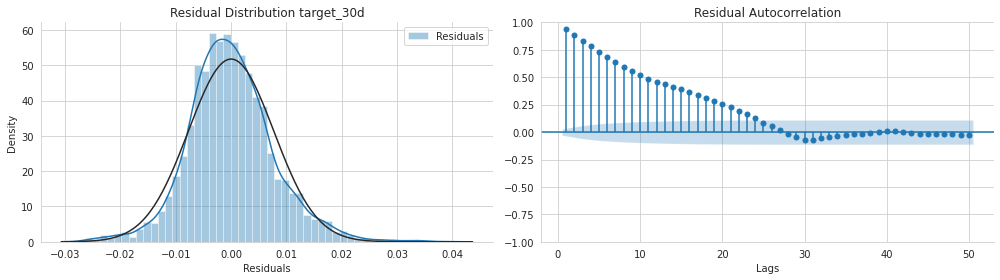

In [14]:
# Monthly OLS plot
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
res_plot = sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title(f'Residual Distribution {target}')
axes[0].legend()
plot_acf(residuals, lags=50, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout()